In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam

In [2]:
import pandas as pd

train_dataset = pd.read_csv('train.csv').values
test_dataset = pd.read_csv('test.csv')

In [3]:
MAX_LENGTH = max(map(lambda x: len(x[0]), train_dataset)) + 1

MAX_LENGTH

40

In [4]:
SOS_token = 0
EOS_token = 1


class Lang:

    def __init__(self, name):
        self.name = name
        self.word2index = {
            'SOS': 0,
            'EOS': 1
        }
        self.index2word = {
            0: 'SOS',
            1: 'EOS'
        }

    @property
    def n_words(self) -> int:
        return len(self.index2word)

    def add_sentence(self, sentence):
        for word in list(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word

In [5]:
input_lang = Lang('human')
output_lang = Lang('iso')

for pair in train_dataset:
    input_lang.add_sentence(pair[0])
    output_lang.add_sentence(pair[1])

print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)

human 82
iso 13


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [8]:
class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        output = self.embedding(x).view(1, 1, -1)
        output = self.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [9]:
def sentence2idx(lang, sentence):
    return [lang.word2index[word] for word in list(sentence)]


def sentence2tensor(lang, sentence):
    indexes = sentence2idx(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def pair2tensor(x):
    input_tensor = sentence2tensor(input_lang, x[0])
    target_tensor = sentence2tensor(output_lang, x[1])
    return input_tensor, target_tensor

In [10]:
teacher_forcing_ratio = 0.5


def train_single(
        input_tensor, target_tensor,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer,
        criterion
):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss = 0

    encoder_hidden = encoder.init_hidden()

    for elem in input_tensor:
        encoder_output, encoder_hidden = encoder(elem, encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for elem in target_tensor:
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, elem)
            decoder_input = elem
    else:
        for elem in target_tensor:
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topi = decoder_output.data.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, elem)
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / len(target_tensor)

In [11]:
import matplotlib.pyplot as plt

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)
    plt.grid()
    plt.ylabel('loss')
    plt.show()

In [12]:
def train(encoder, decoder, n_epochs=5, print_every=100, l_rate=1e-3):
    plot_every = print_every
    encoder.train()
    decoder.train()

    encoder_optimizer = Adam(encoder.parameters(), lr=l_rate)
    decoder_optimizer = Adam(decoder.parameters(), lr=l_rate)

    criterion = nn.NLLLoss()
    
    plot_losses = []

    for epoch in range(n_epochs):
        print_loss_total, plot_loss_total = 0, 0
        loss_count = 0
        
        print(f'Epoch [{epoch + 1:02d}/{n_epochs:02d}]')
        training_pairs = [
            pair2tensor(x) for x in train_dataset[np.random.randint(len(train_dataset), size=len(train_dataset))]
        ]

        for i, training_pair in enumerate(training_pairs):
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = train_single(
                input_tensor, target_tensor,
                encoder, decoder,
                encoder_optimizer, decoder_optimizer,
                criterion
            )
#             print_loss_total += loss
            plot_loss_total += loss
            loss_count += 1
#             if (i + 1) % print_every == 0:
#                 print_loss_avg = print_loss_total / print_every
#                 print_loss_total = 0
#                 print(f'Training ({i / len(training_pairs) * 100:.1f}%) loss: {print_loss_avg:.4f}')
                
        plot_loss_avg = plot_loss_total / loss_count
        plot_losses.append(plot_loss_avg)
        plot_loss_total, loss_count = 0, 0
                
    showPlot(plot_losses)

In [13]:
N_EPOCHS = 30
hidden_size = 128

Epoch [01/30]
Epoch [02/30]
Epoch [03/30]
Epoch [04/30]
Epoch [05/30]
Epoch [06/30]
Epoch [07/30]
Epoch [08/30]
Epoch [09/30]
Epoch [10/30]
Epoch [11/30]
Epoch [12/30]
Epoch [13/30]
Epoch [14/30]
Epoch [15/30]
Epoch [16/30]
Epoch [17/30]
Epoch [18/30]
Epoch [19/30]
Epoch [20/30]
Epoch [21/30]
Epoch [22/30]
Epoch [23/30]
Epoch [24/30]
Epoch [25/30]
Epoch [26/30]
Epoch [27/30]
Epoch [28/30]
Epoch [29/30]
Epoch [30/30]


<Figure size 432x288 with 0 Axes>

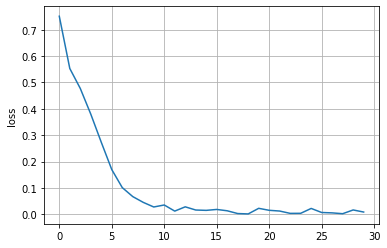

In [14]:
encoder_model = Encoder(input_lang.n_words, hidden_size).to(device)
decoder_model = Decoder(hidden_size, output_lang.n_words).to(device)

train(encoder_model, decoder_model, n_epochs=N_EPOCHS)

In [19]:
@torch.no_grad()
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    encoder.eval()
    decoder.eval()

    input_tensor = sentence2tensor(input_lang, sentence)
    encoder_hidden = encoder.init_hidden()

    for elem in input_tensor:
        encoder_output, encoder_hidden = encoder(elem, encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    decoded_words = []

    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        _, topi = decoder_output.data.topk(1)

        decoded_words.append(output_lang.index2word[topi.item()])

        if topi.item() == EOS_token:
            break

        decoder_input = topi.squeeze().detach()

    return decoded_words


def predict_(encoder, decoder, dataset):
    result = []

    for _ in dataset:
        result.append(evaluate(encoder, decoder, _)[:10])

    return result

In [16]:
test_prediction = predict_(encoder_model, decoder_model, test_dataset['data'])

In [17]:
test_dataset['label'] = [''.join(x) for x in test_prediction]

In [18]:
test_dataset[['id', 'label']].to_csv('submission.csv', index=None)